In [1]:
import numpy as np
from NonlinearController.mpc_utils import *
from NonlinearController.controllers import *
from NonlinearController.model_utils import *
from NonlinearController.lpv_embedding import *
from NonlinearController.systems import UnbalancedDisc
import deepSI
import qpsolvers as qp
import torch
import random
import time

In [2]:
##################  Utility functions  #######################

def differenceVector(X_1, nx):
    return X_1[nx:] - X_1[:-nx]

def extendABC(list_A, list_B, list_C, nx, ny):
    nz = nx+ny
    list_ext_A = np.zeros((nz*Nc,nz))
    list_ext_B = np.zeros((nz*Nc,nu))
    list_ext_C = np.zeros((ny*Nc,nz))

    for i in range(Nc):
        list_ext_A[(i*nz):(i*nz+ny),:ny] = np.eye(ny)
        list_ext_A[(i*nz):(i*nz+ny),ny:nz] = list_C[(ny*i):(ny*i+ny),:]
        list_ext_A[(i*nz+ny):(i*nz+nz),ny:nz] = list_A[(nx*i):(nx*i+nx),:]

    for i in range(Nc):
        list_ext_B[(i*nz+ny):(i*nz+nz),:] = list_B[(nx*i):(nx*i+nx),:]

    for i in range(Nc):
        list_ext_C[(i*ny):(i*ny+ny),:ny] = np.eye(ny)
        list_ext_C[(i*ny):(i*ny+ny),ny:nz] = list_C[(ny*i):(ny*i+ny),:]
    
    return list_ext_A, list_ext_B, list_ext_C

def extendState(Y_1, dX0, nx, ny):
    nz = nx+ny
    Z0 = np.zeros((Nc*nz,1))

    for i in range(Nc):
        Z0[(nz*i):(nz*i+ny),:] = Y_1[ny*i:(ny*i+ny),:]
        Z0[(nz*i+ny):(nz*i+nz),:] = dX0[nx*i:(nx*i+nx),:]

    return Z0

def decodeState(Z0, nx, ny):
    nz = nx+ny
    Y_1 = np.zeros((Nc*ny,1))
    dX0 = np.zeros((Nc*nx,1))

    for i in range(Nc):
        Y_1[ny*i:(ny*i+ny),:] = Z0[(nz*i):(nz*i+ny),:]
        dX0[nx*i:(nx*i+nx),:] = Z0[(nz*i+ny):(nz*i+nz),:]

    return Y_1, dX0

def extendReference(reference, nx, ny, Nc):
    nz = nx+ny

    r = np.zeros((Nc*nz,1))

    for i in range(Nc):
        r[nz*i,0] = reference[i]

    return r

def randomLevelReference(Nsim, nt_range, level_range):
    x_reference_list = np.array([])
    Nsim_remaining = Nsim
    while True:
        Nsim_steps = random.randint(nt_range[0],nt_range[1])
        Nsim_remaining = Nsim_remaining - Nsim_steps
        x_reference_list = np.hstack((x_reference_list, np.ones(Nsim_steps)*random.randint(level_range[0]*10,level_range[1]*10)/10))

        if Nsim_remaining <= 0:
            x_reference_list = x_reference_list[:Nsim]
            break
    return x_reference_list

In [44]:
##################  System  #######################
dt = 0.1
system = UnbalancedDisc(dt=dt, sigma_n=[0.0])
system.reset_state()

##################  MPC variable specification  #######################
model = deepSI.load_system("NonlinearController/trained_models/unbalanced/ObserverUnbalancedDisk_dt01_nab_4_SNR_30_e250")
Nc=10; nr_iterations = 4; nr_sim_steps = 450

w_min = -4; w_max = 4
q_min = [-0.8, -10000, -10000]; q_max = [0.8, 10000, 10000] # augmented with the velocity states
w0 = 0; q0 = 0

In [45]:
reference = randomLevelReference(nr_sim_steps+Nc, [20,25], [-1.2,1.2])
# reference = np.ones(nr_sim_steps+Nc)*1.2
# reference = deepSI.deepSI.exp_design.multisine(nr_sim_steps+Nc, pmax=10, n_crest_factor_optim=20)/1.4
# reference = np.hstack((np.zeros(20), 0.8*np.ones(nr_sim_steps+Nc-20)))
# amp = 0.7; reference = np.tile(np.hstack((-amp*np.ones(30), amp*np.ones(30))), 15)

# np.save("NonlinearController/references/setPoints.npy", reference)
# np.save("NonlinearController/references/setPoints_Range30_50.npy", reference)
# reference = np.load("NonlinearController/references/setPoints.npy")
# plt.plot(reference)

In [46]:
##################  Offline Computation  #######################
nx = model.nx
nu = model.nu if model.nu is not None else 1
ny = model.ny if model.ny is not None else 1
nz = nx+ny
ne = 1

# initialize objective function matrices
R = np.eye(nu)*1; Q = np.matrix('1,0,0;0,1,0;0,0,1')#Q = np.eye(nz)# these are user defined
Psi = get_Psi(Nc, R)
Omega = get_Omega(Nc, Q)
# extended objective matrices for soft constraints
e_lambda = 10000 # weighting of minimizing e in objective function
Ge = np.zeros((Nc*nu+ne,Nc*nu+ne)) 
Ge[-ne:,-ne:] = e_lambda

embedder = velocity_lpv_embedder_autograd(model, Nc, n_stages=20)

# normalize initial input and output
norm = model.norm
u0 = norm_input(w0, norm)
y0 = norm_output(q0, norm)

# initialize observer history input and output
nb = model.nb
uhist = torch.ones((1,nb))*u0
na = model.na
yhist = torch.ones((1,na+1))*y0

# initial predicted states, input, and output
X_1 = np.tile(model.encoder(uhist,yhist).detach().numpy(),Nc+1).T
U_1 = np.ones((Nc+1)*nu)[np.newaxis].T*u0
Y_1 = np.ones((Nc)*ny)[np.newaxis].T *y0

# determine constraint matrices
u_min = norm_input(w_min, norm); u_max = norm_input(w_max, norm)
y_min = norm_output(q_min, norm); y_max = norm_output(q_max, norm)
D, E, M, c = getDEMc(y_min, y_max, u_min, u_max, Nc, nz, nu)
Lambda = np.tril(np.ones((Nc,Nc)),0)

##################  Logging  #######################
log_q = np.zeros((ny,nr_sim_steps))
log_w = np.zeros((nu,nr_sim_steps))
log_e = np.zeros((ne,nr_sim_steps))
log_iterations = np.zeros((1,nr_sim_steps))
log_comp_t = np.zeros((4, nr_sim_steps*nr_iterations))

offset = 0

In [47]:
##################  Online Computation  #######################

#++++++++++++++++++ start simulation step +++++++++++++++++++++++
for k in range(nr_sim_steps):
    # extend normalized reference to form of extended state
    r = extendReference(norm_output(reference[k:k+Nc], norm), nx, ny, Nc)
    
    #++++++++++++++++++ start iteration +++++++++++++++++++++++
    for iteration in range(nr_iterations):
        # determine predicted velocity states and output
        dX0 = differenceVector(X_1, nx)
        dU0 = differenceVector(U_1, nu)
        # determine extended state from predicted output and velocity states
        Z0 = extendState(Y_1, dX0, nx, ny)

        # determine lpv state space dependencies
        component_start = time.time()

        list_A, list_B, list_C = embedder(X_1, U_1)
        list_ext_A, list_ext_B, list_ext_C = extendABC(list_A, list_B, list_C, nx, ny)

        log_comp_t[0, nr_iterations*k + iteration] = log_comp_t[0, nr_iterations*k + iteration] + time.time() - component_start

        # describe optimization problem
        component_start = time.time()

        Phi = get_Phi(list_ext_A, Nc, nz)
        Gamma = get_Gamma(list_ext_A, list_ext_B, Nc, nz, nu)
        G = 2*(Psi + Gamma.T @ Omega @ Gamma)
        F = 2*(Gamma.T @ Omega @ (Phi @ Z0[:nz] - r))
        # describe constraints
        L = (M @ Gamma + E @ Lambda)
        alpha = np.ones((Nc,1))*U_1[0,0]
        W = -(E @ alpha + (D + M @ Phi) @ Z0[:nz])
        # add soft constraints
        Ge[:Nc*nu, :Nc*nu] = G
        Fe = np.vstack((F, np.zeros((ne,1))))
        Le = np.hstack((L, -np.ones((Nc*2*(nz+nu)+2*nz,ne))))

        # solve for optimal U over prediction horizon
        opt_result = qp.solve_qp(Ge,Fe,Le,c+W,solver="osqp")
        # split optimization result in optimal input and soft bound variable e
        dU0[:,0] = opt_result[:Nc*nu]
        e = opt_result[-ne]
        
        # predict states
        Z1 = Phi @ Z0[:nz] + Gamma @ dU0
        # split extended state up into ouputs and velocity states
        Y0, dX1 = decodeState(Z1, nx, ny)
        # overwrite previous predicted states and output with new predicted states and output
        Y_1[2*ny:,0] = Y0[ny:-ny,0]; dX0[nx:,0] = dX1[:-nx,0] #change the shifting on the output to be consequential
        # save previous iteration of U_1
        U_1_old = np.copy(U_1)
        # determine new X_1 states from known x0 and predicted dX0
        for i in range(2,Nc+1):
            X_1[(i*nx):(i*nx+nx),:] = dX0[((i-1)*nx):((i-1)*nx+nx),:] + X_1[((i-1)*nx):((i-1)*nx+nx),:]
        for i in range(2,Nc+1):
            U_1[(i*nu):(i*nu+nu),:] = dU0[((i-1)*nu):((i-1)*nu+nu),:] + U_1[((i-1)*nu):((i-1)*nu+nu),:]

        log_comp_t[1, nr_iterations*k + iteration] = log_comp_t[1, nr_iterations*k + iteration] + time.time() - component_start

        # stopping condition
        if np.linalg.norm(U_1 - U_1_old) < 1e-1:
            break
    #++++++++++++++++++ end iteration +++++++++++++++++++++++
    
    # determine input from optimal velocity input
    u0 = dU0[:nu,0] + U_1[:nu,0]
    # denormalize input
    w0 = denorm_input(u0, norm)
    # measure output then apply input
    system.x = system.f(system.x, w0[0])
    q1 = system.h(system.x, w0[0])

    # normalize output
    y1 = norm_output(q1, norm)

    # shift history input and output for encoder
    for j in range(nb-1):
        uhist[0,j] = uhist[0,j+1]
    uhist[0,nb-1] = torch.Tensor(u0)
    for j in range(na):
        yhist[0,j] = yhist[0,j+1]
    yhist[0,na] = torch.Tensor([y1])
    # predict state with encoder
    x1 = model.encoder(uhist,yhist)

    # shift predicted states, input, and output one time step k; and replace with measured/observed values
    X_1[:-nx, :] = X_1[nx:, :]; X_1[-nx:, :] = X_1[-2*nx:-nx, :]; X_1[nx:2*nx, :] = x1.detach().numpy().T
    U_1[:-nu, :] = U_1[nu:, :]; U_1[-nu:, :] = U_1[-2*nu:-nu, :]; U_1[:nu, :] = u0
    Y_1[:-ny, :] = Y_1[ny:, :]; Y_1[-ny:, :] = Y_1[-2*ny:-ny, :]; Y_1[ny:2*ny, :] = y1

    # log system signals
    log_q[:,k] = q1
    log_w[:,k] = w0
    log_e[:,k] = e
    log_iterations[:,k] = iteration+1
    
    # print progress
    print("Sim step: " + str(k) + ", iterations: " + str(iteration+1))
    
#++++++++++++++++++ end simulation step +++++++++++++++++++++++

Sim step: 0, iterations: 3
Sim step: 1, iterations: 2
Sim step: 2, iterations: 2
Sim step: 3, iterations: 2
Sim step: 4, iterations: 1
Sim step: 5, iterations: 1
Sim step: 6, iterations: 1
Sim step: 7, iterations: 1
Sim step: 8, iterations: 1
Sim step: 9, iterations: 1
Sim step: 10, iterations: 1
Sim step: 11, iterations: 1
Sim step: 12, iterations: 1
Sim step: 13, iterations: 2
Sim step: 14, iterations: 2
Sim step: 15, iterations: 2
Sim step: 16, iterations: 2
Sim step: 17, iterations: 2
Sim step: 18, iterations: 2
Sim step: 19, iterations: 2
Sim step: 20, iterations: 1
Sim step: 21, iterations: 1
Sim step: 22, iterations: 1
Sim step: 23, iterations: 1
Sim step: 24, iterations: 1
Sim step: 25, iterations: 1
Sim step: 26, iterations: 1
Sim step: 27, iterations: 1
Sim step: 28, iterations: 1
Sim step: 29, iterations: 1
Sim step: 30, iterations: 1
Sim step: 31, iterations: 1
Sim step: 32, iterations: 1
Sim step: 33, iterations: 1
Sim step: 34, iterations: 1
Sim step: 35, iterations: 2
Si

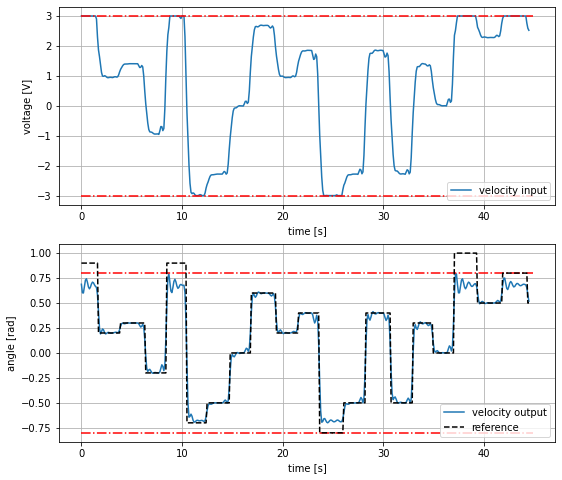

In [48]:
# logs from other scripts
log_q_nmpc = np.load("NonlinearController/experiments/log_q.npy")
log_w_nmpc = np.load("NonlinearController/experiments/log_w.npy")
log_u_lpv = np.load("NonlinearController/experiments/u_log.npy")
log_y_lpv = np.load("NonlinearController/experiments/y_log.npy")

fig1 = plt.figure(figsize=[8.9, 8])

start_offset = 4

plt.subplot(2,1,1)
plt.plot(np.arange(nr_sim_steps-start_offset)*dt, log_w[0,start_offset:], label='velocity input')
# plt.plot(np.arange(nr_sim_steps-start_offset)*dt, np.hstack((log_u_lpv[1+start_offset:],log_u_lpv[-1])), label='lpv input')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_max, 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_min, 'r-.')#, label='min')
plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.grid()
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(np.arange(nr_sim_steps-start_offset)*dt, log_q[0,start_offset:], label='velocity output')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*q_max[0], 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*q_min[0], 'r-.')#, label='min')
# plt.plot(np.arange(nr_sim_steps-start_offset)*dt, np.hstack((log_y_lpv[2+start_offset:],log_y_lpv[-1])), label='lpv output')
plt.plot(np.arange(nr_sim_steps-start_offset)*dt, np.hstack((reference[1+start_offset:nr_sim_steps],reference[nr_sim_steps])), 'k--', label='reference')
# plt.plot(np.arange(nr_sim_steps)*dt, log_q[0,:] - log_q_nmpc[0,:], label='vel-nmpc')

plt.xlabel("time [s]")
plt.ylabel("angle [rad]")
plt.grid()
plt.legend(loc='lower right')

# plt.subplot(2,2,3)
# plt.plot(np.arange(nr_sim_steps)*dt, log_e[0,:], label='e')
# plt.xlabel("time [s]")
# plt.ylabel("e")
# plt.grid()
# plt.legend(loc='upper right')

# plt.subplot(2,2,4)
# plt.plot(np.arange(nr_sim_steps)*dt, log_iterations[0,:], label='iQP')
# plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*nr_iterations, 'r-.', label='max iter')
# plt.xlabel("time [s]")
# plt.ylabel("iterations")
# plt.grid()
# plt.legend(loc='upper right')

plt.savefig("Figures/offset_free_comparison.svg")
plt.show()

In [16]:
CT_iters = np.split(log_comp_t, nr_sim_steps, axis=1)
CT = np.sum(CT_iters[0], axis=1)

remove_start = 0
S_iter = np.zeros(nr_sim_steps-remove_start)
T_iter = np.zeros(nr_sim_steps-remove_start)

for i in range(remove_start,nr_sim_steps):
    CT = np.sum(CT_iters[i], axis=1)
    S_iter[i-remove_start] = CT[1]
    T_iter[i-remove_start] = np.sum(CT)

Sorted = np.sort(T_iter)
# np.max(T_iter)*1000, np.mean(Sorted[int(nr_sim_steps*0.95):])*1000, np.mean(T_iter)*1000, np.std(T_iter)*1000, np.mean(S_iter)*1000 #in ms
np.max(T_iter)*1000,  np.mean(T_iter)*1000, np.std(T_iter)*1000, np.mean(S_iter)*1000 #in ms

(69.99707221984863, 12.95822090572781, 6.752010208449065, 3.7706682417127824)

In [17]:
np.unique(log_iterations, return_counts=True)

(array([1., 2.]), array([340, 110], dtype=int64))

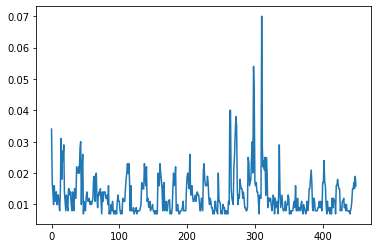

In [18]:
plt.plot(T_iter)

In [ ]:
fig2 = plt.figure(figsize=[8.9, 4.0])#['getAB', 'solve', 'overhead', 'sim']
data1 = np.trim_zeros(log_comp_t[0,remove_start*nr_iterations:])
data2 = np.trim_zeros(log_comp_t[1,remove_start*nr_iterations:])
data3 = np.trim_zeros(log_comp_t[2,remove_start*nr_iterations:])
data4 = np.trim_zeros(log_comp_t[3,remove_start*nr_iterations:])
data = [data1, data2, data3, data4]
plt.boxplot(data)
plt.xticks([1, 2, 3, 4],  ['getAB', 'solve', 'overhead', 'sim'])
plt.grid(axis='y')
plt.ylabel("time [s]")
plt.xlabel("components")
plt.show()